# Predicting the NBA Draft

### By Isaac Butz, Zongxia Li, and Laksh Sekhri

---


Welcome to our tutorial! In this project, the goal is to look at what factors are the most important for NBA draft picks. First, a little bit about the NBA. The National Basketball Association, or NBA, is the highest level professional basketball league in the world. It is composed of 30 teams that play 82 games each, before a playoff bracket is set. The most common way for players to enter the league (After 2006, read more about the rule change [here](https://en.wikipedia.org/wiki/Eligibility_for_the_NBA_draft) is to be drafted in the NBA draft. Most players drafted come from collegiate basketball, more specifically NCAA D1 Mens Basketball. The draft consists of 2 rounds, with each team getting 1 pick per round, for a total of 60 picks. 

The end goal of this project is to try and predict the [2021 NBA draft](https://en.wikipedia.org/wiki/2021_NBA_draft) that will take place on July 29th. Finding out the position of draft picks would be useful for those in the sports industry. A team would be able to predict what players other teams will select, see if players are over/under-rated, or possibly help set sports betting odds. However to start predicting the draft, we must look at past drafts to see what are the most important factors for an NBA draft pick. The project will be broken up into 5 sections:

>0. [Setup](#setup)
>
>
>1. [Data Wrangling](#part1)
>   - [a: Previous draft picks](#step1a)
>   - [b: Current draft picks](#step1b)
>
>
>2. [Analysis of Previous Drafts](#part2)
>   - [a: Analyzing Players Stats](#step2a)
>   - [b: Getting More Data](#step2b)
>   - [c: Further Analysis](#step2c)
>
>
>3. [Building a Model](#part3)
>   - [a: Finding the best model](#step3a)
>   - [b: Model Comparison and Prediction](#step3b)
>
>
>4. [Conclusion](#conc)


Over the course of this guide, we hope the reader is able to understand how and why data analysis is done, and would be able to follow similar steps to do some data science on other topics!

<a id='setup'></a>
# Part 0: Setup

The following imports and libraries will be used. If you want to read the documentation, click below.

- [pandas](https://pandas.pydata.org/)
- [numpy](https://numpy.org/)
- [requests](https://docs.python-requests.org/en/master/)
- [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- [matplotlib](https://matplotlib.org/)
- [sklearn](https://scikit-learn.org/stable/)

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# These are for the machine learning
import matplotlib as matlib
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

!pip3 install lxml

<a id='part1'></a>
# Part 1: Data Wrangling

Perhaps the most important part is to get the data. This first dataset needed is a collection of past NBA draft picks college stats. This is what we will do analysis on, and train our machine learning model on. We found the website [barttorvik.com](https://www.barttorvik.com/playerstat.php?link=y&year=2022&start=20211101&end=20220501) that contains data on NCAA mens basketball players. Secondly, a dataset is needed for the current NBA draft class. With these two data sets we will be able to inspect our data and do preliminary hypothesis testing, create a model for the data, and lastly try to predict this current years draft order.

<a id='step1a'></a>
## Step a: Previous NBA drafts

Unfortunately, the data is generated using javascript and we were unable to parse it, so it was done manually. Here are the steps. From [here](https://www.barttorvik.com/playerstat.php?link=y&year=2022&start=20211101&end=20220501), under the top drop down menu 'all' was selected to get all time. Next, scrolling down the left side, Min%, O-Reb%, D-Reb%, Ast%, Blk%, Stl%, FTR, 2PM, 3PM, and drafted were selected to be shown. Drafted was also set to "<=" and "60", since there are 60 picks in the NBA draft. After that, "name" was clicked twice so the players were sorted by name. Then, the "Show 100 more" option was repeatedly selected, until the full 1302 element table was shown. Lastly, the entire table was selected using a cursor, and copy/pasted into a blank csv file that was read into `pandas`.

The better approach would be to use a library such a `selenium`, however we had difficulties figuring this out.

In [2]:
# Start by reading in from the csv we manually created
pastPicks_df = pd.read_csv('past_college_players.csv', '\t')
pastPicks_df.head()

,,,,RK,PICK,PLAYER,TEAM,CONF,MIN%,OR,DR,AST,BLK,STL,FTR,2P,3P,YEAR
1,46,Fr,7-0,A.J. Hammons (13),Purdue,B10,57.4,11.6,17.3,6.2,8.7,0.9,41.0,140-283,0.495,0-0,0.000,2013
2,46,So,7-0,A.J. Hammons (14),Purdue,B10,59.6,10.1,22.8,4.2,13.2,0.9,62.2,114-220,0.518,0-5,0.000,2014
3,46,Jr,7-0,A.J. Hammons (15),Purdue,B10,60.1,12.2,19.7,9.1,12.3,1.3,46.7,157-284,0.553,0-7,0.000,2015
4,46,Sr,7-0,A.J. Hammons (16),Purdue,B10,57.5,11.5,24.8,10.5,10.4,0.7,37.8,193-325,0.594,6-11,0.545,2016
5,52,Jr,6-2,A.J. Price (08),Connecticut,BE,79.7,2.8,8.1,36.1,0.3,2.3,38.8,108-225,0.480,52-141,0.369,2008


The data is super messey. We want to fix it and have the following columns:

- 'pick': What pick of the draft they were
- 'class': Their college class
- 'player': The player's name
- 'minutes_per': Percentage of the game played
- 'off_reb_per': [ORB%](https://www.basketball-reference.com/about/glossary.html#orb)
- 'def_reb_per': [DRB%](https://www.basketball-reference.com/about/glossary.html#drb)
- 'assist_per': [AST%](https://www.basketball-reference.com/about/glossary.html#ast)
- 'block_per': [BLK%](https://www.basketball-reference.com/about/glossary.html#blk)
- 'steal_per': [STL%](https://www.basketball-reference.com/about/glossary.html#stl)
- 'free_throw_per': [FT%](https://www.basketball-reference.com/about/glossary.html#ft)
- 'two_point_per': [2P%](https://www.basketball-reference.com/about/glossary.html#fg2)
- 'three_point_per': [3P%](https://www.basketball-reference.com/about/glossary.html#fg3)

The last 8 are hyperlinks to a gloassary by [basketball-reference.com](https://www.basketball-reference.com/about/glossary.html) that further explains what these columns mean.

In [3]:
# Create a 2d array that has 12 arrays for our 12 categories
data = [[], [], [], [], [], [], [], [], [], [], [], []]
for i, r in pastPicks_df.iterrows():
    data[0].append(i[1])
    data[1].append(i[2])
    data[2].append(r['RK'][slice(0, len(r['RK']) - 5)])
    data[3].append(r['TEAM'])
    data[4].append(r['CONF'])
    data[5].append(r['MIN%'])
    data[6].append(r['OR'])
    data[7].append(r['DR'])
    data[8].append(r['AST'])
    data[9].append(r['BLK'])
    data[10].append(r['FTR'])
    data[11].append(r['3P'])

headers = ['pick', 'class', 'player', 'minutes_per', 'off_reb_per',
           'def_reb_per', 'assist_per', 'block_per', 'steal_per', 'free_throw_per',
           'two_point_per', 'three_point_per']

# pandas reads in row wise, so I use T to take the transpose
pastPicks_df = pd.DataFrame(np.array(data).T, columns=headers)

# Outputting this to a csv for data_training
pastPicks_df.to_csv('allyears.csv')

# Next, only take a players final year in the NCAA. 
# Thankfully, the way the data is formatted all I have to do is get last occurance of each player
pastPicks_df = pastPicks_df.drop_duplicates(subset='player', keep='last', ignore_index=True)

# Lastly, I want to make sure we have our columns as numeric data
for c in pastPicks_df.columns:
    if c != 'class' and c != 'player':
        pastPicks_df[c] = pd.to_numeric(pastPicks_df[c])

# Push it to csv for later use as well
pastPicks_df.to_csv('cleaned_train.csv')

pastPicks_df.head()

,pick,class,player,minutes_per,off_reb_per,def_reb_per,assist_per,block_per,steal_per,free_throw_per,two_point_per,three_point_per
0,46,Sr,A.J. Hammons,57.5,11.5,24.8,10.5,10.4,0.7,37.8,0.594,0.545
1,52,Sr,A.J. Price,73.0,2.1,9.2,28.5,0.0,1.2,30.3,0.422,0.398
2,4,Fr,Aaron Gordon,77.1,10.4,19.3,13.0,3.4,1.8,47.1,0.513,0.356
3,23,Jr,Aaron Holiday,92.1,1.6,8.7,29.9,0.7,1.9,41.7,0.486,0.429
4,14,Fr,Aaron Nesmith,72.2,4.2,17.3,10.8,2.1,1.4,27.5,0.474,0.337


<a id='step1b'></a>
## Step b: This year's draft

Unfortunately we will not be able to predict everyone in the draft. This is because the deadline for players to announce for the NBA draft is May 30th, and this project is due May 17th. However, most players who will be picked higher up in the rankings declare earlier for the draft, so we can use these early declarations for predictions. [This website](https://ca.nba.com/news/2021-nba-draft-ncaa-players-that-have-declared-for-the-2021-nba-draft-e/hphzsl6bo6dh16t9tpee5628y) contains a nice table of all the players who have declared early thus far. 

Next, we use this list of names as a cross reference for the 2021 season stats, getting the 2021 season players stats from barttorvik.com again. Like before, this data is created using javascript, so here are the steps for how we manually got the data. First, go to [barttorvik player stats](https://www.barttorvik.com/playerstat.php?year=2021). Make sure the year is 2021. Next, select Min%, O-Reb%, D-Reb%, Ast%, Blk%, Stl%, FTR, 2PM, and 3PM. And once again, show 100 more was selected repeatedly until all 2125 players were visible. Lastly, this was copy/pasted into a csv file, which is read in and processed.

In [4]:
# HTML Scraping the list of early draft commits using requests, BeautifulSoup, and pandas
r = requests.get("https://ca.nba.com/news/2021-nba-draft-ncaa-\
                 players-that-have-declared-for-the-2021-nba-draft-e/hphzsl6bo6dh16t9tpee5628y")
soup = BeautifulSoup(r.content, 'lxml')

# Find the table in the html, thankfully only one
html_table = soup.find("table")
earlycomm_df = pd.read_html(str(html_table), header=0)[0]
earlycomm_df.head()

,Player,Position,Year,School
0,Ochai Agbaji,SG,Jr.,Kansas
1,James Akinjo,PG,Jr.,Arizona
2,Keve Aluma,PF,R-Jr.,Virginia Tech
3,Jose Alvarado,PG,Sr.,Georgia Tech
4,Avery Anderson III,PG,So.,Oklahoma State


In [5]:
# Moving onto the 2021 season data, we read in our player data from the csv 
stats2021_df = pd.read_csv('2021season.csv', '\t')
stats2021_df.head()

,,,,RK,PLAYER,TEAM,CONF,MIN%,OR,DR,AST,BLK,STL,FTR,2P,3P
1,Jr,6-5,A.J. Caldwell,Chattanooga,SC,80.2,1.6,14.9,13.7,1.3,2.1,9.2,15-41,0.366,36-90,0.400
2,Sr,6-5,A.J. Lawson,McNeese St.,Slnd,73.3,5.3,14.9,33.9,0.4,1.4,42.3,58-122,0.475,11-34,0.324
3,Jr,6-5,A.J. Oliver II,Old Dominion,CUSA,66.9,2.5,8.9,7.3,0.8,1.1,19.2,36-65,0.554,32-102,0.314
4,So,6-2,A.J. Plitzuweit,South Dakota,Sum,75.6,2.4,11.6,23.4,0.3,1.5,38.3,76-165,0.461,52-117,0.444
5,Jr,6-6,A.J. Reeves,Providence,BE,77.2,2.3,10.6,10.3,0.3,1.9,23.2,31-74,0.419,48-150,0.320


To clean us this `DataFrame`, I am going to follow almost exactly the same steps as I did in [step a](#parta). The columns will be the exact same, except there won't be a 'pick' column.

In [6]:
# Create a 2d array that has 11 arrays for our 11 categories
data = [[], [], [], [], [], [], [], [], [], [], []]
for i, r in stats2021_df.iterrows():
    data[0].append(i[1])
    data[1].append(i[3])
    data[2].append(r['TEAM'])
    data[3].append(r['CONF'])
    data[4].append(r['MIN%'])
    data[5].append(r['OR'])
    data[6].append(r['DR'])
    data[7].append(r['AST'])
    data[8].append(r['BLK'])
    data[9].append(r['FTR'])
    data[10].append(r['3P'])

# pandas reads in row wise, so I use T to take the transpose
temp = pd.DataFrame(np.array(data).T, columns=headers[1:])

# Cross reference to get players who have declared for the draft
temp = temp.where(temp['player'].isin(earlycomm_df['Player']))
stats2021_df = temp.dropna(how='all').reset_index(drop=True)

# Once again, I want to make sure we have numerical data
for c in stats2021_df.columns:
    if c != 'class' and c != 'player':
        stats2021_df[c] = pd.to_numeric(stats2021_df[c])


# push to csv for later
stats2021_df.to_csv('cleaned2021.csv')

stats2021_df.head()

,class,player,minutes_per,off_reb_per,def_reb_per,assist_per,block_per,steal_per,free_throw_per,two_point_per,three_point_per
0,Jr,Aaron Henry,80.9,4.8,14.6,25.2,4.1,2.4,28.9,0.493,0.296
1,Jr,Aaron Wiggins,83.3,4.5,15.9,17.2,2.0,2.1,20.3,0.515,0.346
2,Jr,Alan Griffin,72.8,6.3,15.2,12.2,6.6,2.3,19.0,0.514,0.354
3,Sr,Alfonso Plummer,69.8,1.3,7.9,7.5,0.2,1.5,12.1,0.526,0.383
4,So,Armando Bacot,56.6,14.5,22.3,7.3,4.3,1.6,58.3,0.631,0.000


<a id='part2'></a>
# Part 2

Now that all the data has been collected, the data analysis can begin. The goal is to look for trends between high draft picks and player's stats. If any trends can be observed, that would be something to train our model on. For plotting we will use `matplotlib` to display the data. 

<a id='step2a'></a>
## Step a: Players stats
We will start off with plotting possibly the most simple breakdown, age. A common sentiment among basketball fans, and our hypothesis, is that a younger player is drafted earlier. This is because the NBA teams want to develop the player on their own and younger players adapt more easily. At the same time, we can plot draft pick over minutes played to see how time spent in game correlates with draft position. Finally, we will look at the players stats to see if there are any correlations between players stats and draft placement.

In [7]:
# Set up for this plot
classes = ['Fr', 'So', 'Jr', 'Sr']
colors = ['red', 'yellow', 'blue', 'green']
by_age = []

# Use a list comprehension 4 times
for c in classes:
    # Get 4 lists, each one contains draft picks from that class
    by_age.append([r['pick'] for i, r in pastPicks_df.iterrows() if r['class'] == c])

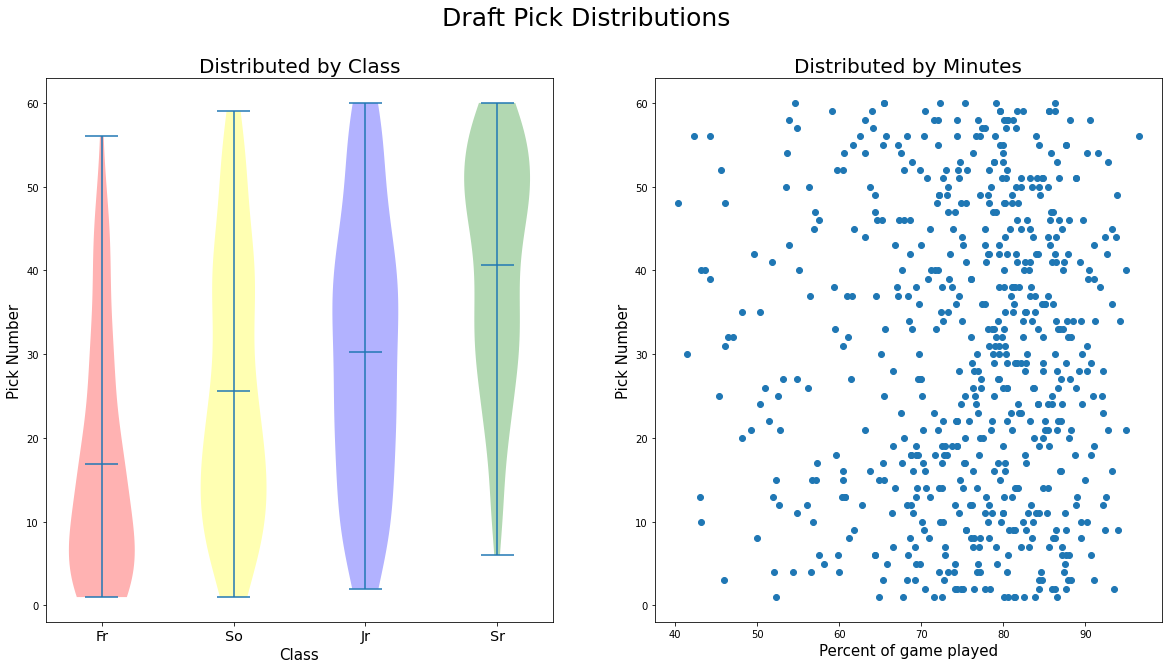

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Plotting by class
parts1 = ax1.violinplot(by_age, range(len(classes)), showmeans=True)

# Plotting Pick over minutes played.
parts2 = ax2.scatter(pastPicks_df['minutes_per'], pastPicks_df['pick'])

# Setting plot colors
for i, pc in enumerate(parts1['bodies']):
    pc.set_facecolor(colors[i])

# Titles/labels
plt.suptitle("Draft Pick Distributions", fontsize=25)
ax1.set_title("Distributed by Class", fontsize=20)
ax1.set_xlabel('Class', fontsize=15)
ax1.set_ylabel('Pick Number', fontsize=15)

ax2.set_title("Distributed by Minutes", fontsize=20)
ax2.set_xlabel('Percent of game played', fontsize=15)
ax2.set_ylabel('Pick Number', fontsize=15)

plt.sca(ax1)
plt.xticks(range(len(classes)), classes, fontsize='x-large')

plt.show()

Looking at the plot on the left it seems that if a freshman is going to be drafted, they will be picked early in the draft. Seniors are the opposite, often being picked at the end of the draft. The distribution seems to be somewhat linear, so this could be a good parameter for training our model on. This is in line with our hypothesis. Conversely, the distribution of pick number over minutes played shows almost no correlation. It is a total mess and thus it will not be something that we will use in our preditctive model.

Next, we will look at how the players stats impact their draft position. First, we will look at all the players stats against draft pick to see if there is any basic correlation.

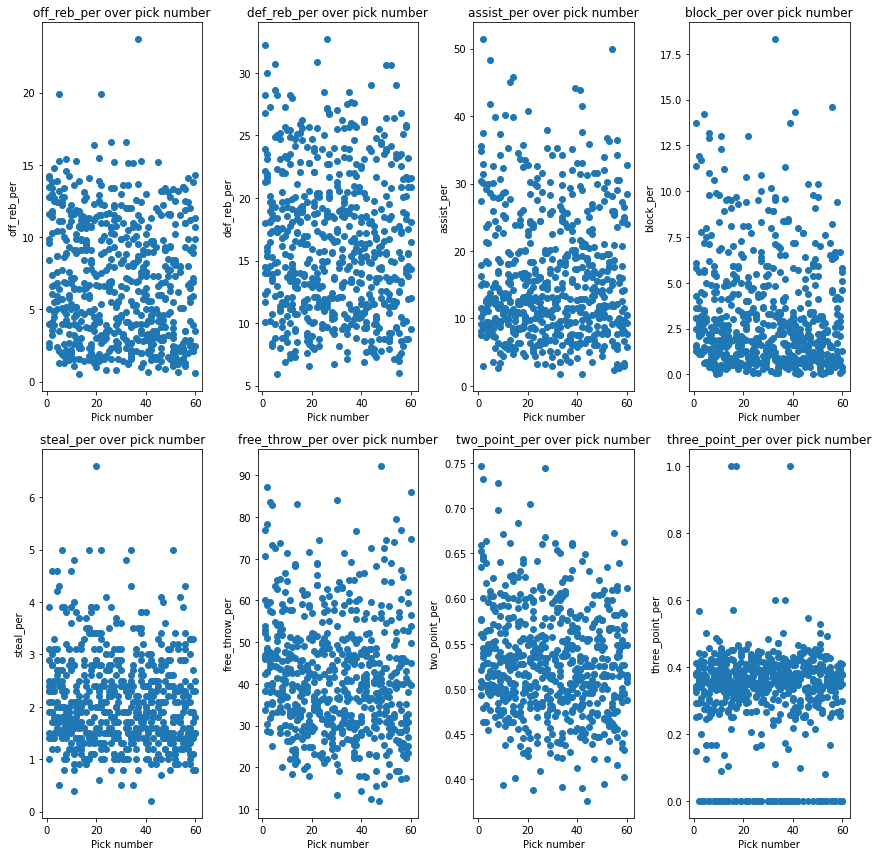

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(12,12))
titles = pastPicks_df.columns[4:]

for i, row in enumerate(axs):
    for j, plot in enumerate(row):
        title = titles[4*i + j]
        plot.scatter(pastPicks_df['pick'], pastPicks_df[title])
        plot.set_xlabel("Pick number")
        plot.set_ylabel(title)
        plot.set_title(title + " over pick number")
        
        
fig.tight_layout()
plt.show()

There seems to be no correlation between draft pick and any of these stats. Every plot is a mess. This means that there is no specifc player stat that really makes or breaks their draft position. This makes sense considering the variety of positions in basketball and the different skill sets. Some years teams may want a defensive minded player that gets a lot of steals and blocks, or teams may draft a good shooter really high. 

<a id='step2b'></a>
## Step b: Getting more data

Since there seems to be no correlation there, we are going to loop back in the data science pipeline to collecting data. Perhaps there is a stronger relationship with biometrics: height, weight, vertical, etc. We found this data on [Data World](https://data.world/achou/nba-draft-combine-measurements). To access it you do have to make an account, however this is free and simple. The data was read in and joined to our existing `pastPicks_df`.

In [10]:
biometric_df = pd.read_csv("nba_draft_combine_all_years.csv", index_col=0)
biometric_df.head()

,Player,Year,Draft pick,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,Blake Griffin,2009,1.0,80.50,82.00,83.25,105.0,35.5,140.5,32.0,137.0,248.0,8.2,NaN,NaN,22.0,10.95,3.28
1,Terrence Williams,2009,11.0,77.00,78.25,81.00,103.5,37.0,140.5,30.5,134.0,213.0,5.1,NaN,NaN,9.0,11.15,3.18
2,Gerald Henderson,2009,12.0,76.00,77.00,82.25,102.5,35.0,137.5,31.5,134.0,215.0,4.4,NaN,NaN,8.0,11.17,3.14
3,Tyler Hansbrough,2009,13.0,80.25,81.50,83.50,106.0,34.0,140.0,27.5,133.5,234.0,8.5,NaN,NaN,18.0,11.12,3.27
4,Earl Clark,2009,14.0,80.50,82.25,86.50,109.5,33.0,142.5,28.5,138.0,228.0,5.2,NaN,NaN,5.0,11.17,3.35


In [11]:
pastPicks_df = pastPicks_df.join(biometric_df)
# Dropping duplicate columns
pastPicks_df.drop(['Player', 'Year', 'Draft pick'], axis=1, inplace=True)
pastPicks_df.head()

,pick,class,player,minutes_per,off_reb_per,def_reb_per,assist_per,block_per,steal_per,free_throw_per,...,Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,46,Sr,A.J. Hammons,57.5,11.5,24.8,10.5,10.4,0.7,37.8,...,140.5,32.0,137.0,248.0,8.2,NaN,NaN,22.0,10.95,3.28
1,52,Sr,A.J. Price,73.0,2.1,9.2,28.5,0.0,1.2,30.3,...,140.5,30.5,134.0,213.0,5.1,NaN,NaN,9.0,11.15,3.18
2,4,Fr,Aaron Gordon,77.1,10.4,19.3,13.0,3.4,1.8,47.1,...,137.5,31.5,134.0,215.0,4.4,NaN,NaN,8.0,11.17,3.14
3,23,Jr,Aaron Holiday,92.1,1.6,8.7,29.9,0.7,1.9,41.7,...,140.0,27.5,133.5,234.0,8.5,NaN,NaN,18.0,11.12,3.27
4,14,Fr,Aaron Nesmith,72.2,4.2,17.3,10.8,2.1,1.4,27.5,...,142.5,28.5,138.0,228.0,5.2,NaN,NaN,5.0,11.17,3.35


Here is a description of the new dataframe. The first 12 columns are the same, and the new columns have mostly self explanatory. As you can see in the `Non-Null Count`, the measurments we added were not up to date. Some columns, such as "Bench", only have 284 out of 621 entries. However this should be enough data to do more hypothesis testing on.

In [12]:
pastPicks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pick                      621 non-null    int64  
 1   class                     621 non-null    object 
 2   player                    621 non-null    object 
 3   minutes_per               621 non-null    float64
 4   off_reb_per               621 non-null    float64
 5   def_reb_per               621 non-null    float64
 6   assist_per                621 non-null    float64
 7   block_per                 621 non-null    float64
 8   steal_per                 621 non-null    float64
 9   free_throw_per            621 non-null    float64
 10  two_point_per             621 non-null    float64
 11  three_point_per           621 non-null    float64
 12  Height (No Shoes)         517 non-null    float64
 13  Height (With Shoes)       516 non-null    float64
 14  Wingspan  

<a id='step2c'></a>
## Step c: Further Analysis

In this section, we will do scatter plots on different biometrics vs. pick of the player and see which biometric affects the player's pick position the most

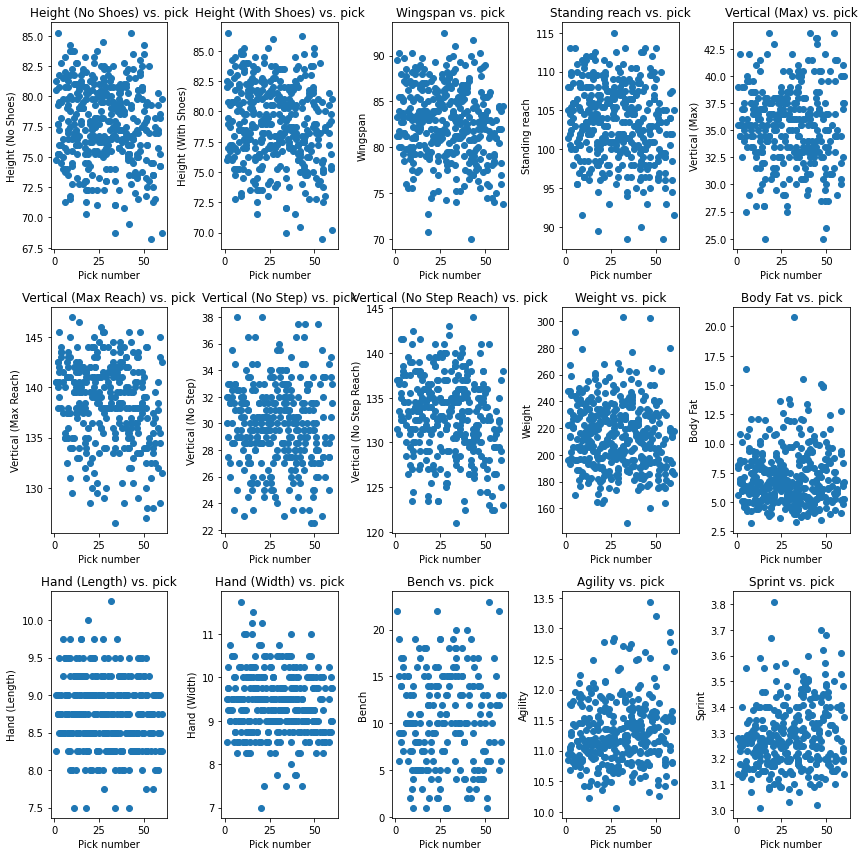

In [13]:
# See the correlation between each biometric and the pick of the player in a scatter plot
metrics , i = [], 0
# fig, axs = plt.subplots(2, 4, figsize=(12,12))
for col in biometric_df.columns:
    if i > 2:
        metrics.append(col)
    i += 1
    
pick = biometric_df['Draft pick']
fig, axs = plt.subplots(3, 5, figsize=(12,12))

count = 0
for i, row in enumerate(axs):
    for j, plot in enumerate(row):
        plot.scatter(pick, biometric_df[metrics[count]])
#         fit = np.polyfit(biometric_df[metrics[count]], pick, deg=1)
#         plot.plot(biometric_df[metrics[count]], fit[0] * np.array(biometric_df[metrics[count]]) + fit[1], color='r')
        plot.set_xlabel("Pick number")
        plot.set_ylabel(metrics[count])
        plot.set_title(metrics[count] + " vs. pick")
        count += 1
        
        
fig.tight_layout()
plt.show()

<a id='part3'></a>
# Part 3

Next we can try to train a model to predict the 2021 NBA draft. There aren't too many good parameters, so for the most part we will be training on all of the data points.

<a id='step3a'></a>
## Step a: Training and Finding the Best Model

We will use these features as input of our different models and pick as the output of those models. We will train the data using K nearest neighbor model, support vector machine, logistic regression and multi layer perceptron. Then we will see how accurate each model is on fitting the traning dataset. And we will pick the top 2 models that perform the best and use the models to predict the draft for 2021.


### Collecting training data and testing data
We are taking the NBA drafts data from previous year starting from 2008 use differnet models
to test how accurate each model is to predict the draft picks for NBA players. Then we will use the most accurate model to predict the NBA draft pick for 2021.

In [14]:
train = pd.read_csv("allyears.csv") 
train.head()

,Unnamed: 0,pick,class,player,minutes_per,off_reb_per,def_reb_per,assist_per,block_per,steal_per,free_throw_per,two_point_per,three_point_per
0,0,46,Fr,A.J. Hammons,57.4,11.6,17.3,6.2,8.7,0.9,41.0,0.495,0.000
1,1,46,So,A.J. Hammons,59.6,10.1,22.8,4.2,13.2,0.9,62.2,0.518,0.000
2,2,46,Jr,A.J. Hammons,60.1,12.2,19.7,9.1,12.3,1.3,46.7,0.553,0.000
3,3,46,Sr,A.J. Hammons,57.5,11.5,24.8,10.5,10.4,0.7,37.8,0.594,0.545
4,4,52,Jr,A.J. Price,79.7,2.8,8.1,36.1,0.3,2.3,38.8,0.480,0.369


In [15]:
test = pd.read_csv("cleaned2021.csv") 
test.head()

,Unnamed: 0,class,player,minutes_per,off_reb_per,def_reb_per,assist_per,block_per,steal_per,free_throw_per,two_point_per,three_point_per
0,0,Jr,Aaron Henry,80.9,4.8,14.6,25.2,4.1,2.4,28.9,0.493,0.296
1,1,Jr,Aaron Wiggins,83.3,4.5,15.9,17.2,2.0,2.1,20.3,0.515,0.346
2,2,Jr,Alan Griffin,72.8,6.3,15.2,12.2,6.6,2.3,19.0,0.514,0.354
3,3,Sr,Alfonso Plummer,69.8,1.3,7.9,7.5,0.2,1.5,12.1,0.526,0.383
4,4,So,Armando Bacot,56.6,14.5,22.3,7.3,4.3,1.6,58.3,0.631,0.000


In [16]:
# Convert the classes to numbers for the train dataset
# Senior gets 4, junior gets 3, sophmore gets 2, freshman gets 1
classes = []
for row in train.iterrows():
    classification = row[1][2]
    if classification == 'Sr':
        classes.append(4)
    elif classification == 'Fr':
        classes.append(1)
    elif classification == 'Jr':
        classes.append(3)
    else:
        classes.append(2)
        
train['class1'] = classes
train.head()

,Unnamed: 0,pick,class,player,minutes_per,off_reb_per,def_reb_per,assist_per,block_per,steal_per,free_throw_per,two_point_per,three_point_per,class1
0,0,46,Fr,A.J. Hammons,57.4,11.6,17.3,6.2,8.7,0.9,41.0,0.495,0.000,1
1,1,46,So,A.J. Hammons,59.6,10.1,22.8,4.2,13.2,0.9,62.2,0.518,0.000,2
2,2,46,Jr,A.J. Hammons,60.1,12.2,19.7,9.1,12.3,1.3,46.7,0.553,0.000,3
3,3,46,Sr,A.J. Hammons,57.5,11.5,24.8,10.5,10.4,0.7,37.8,0.594,0.545,4
4,4,52,Jr,A.J. Price,79.7,2.8,8.1,36.1,0.3,2.3,38.8,0.480,0.369,3


In [17]:
# Convert the classes to numbers for the test dataset
classes = []
for row in test.iterrows():
    classification = row[1][2]
    if classification == 'Sr':
        classes.append(4)
    elif classification == 'Fr':
        classes.append(1)
    elif classification == 'Jr':
        classes.append(3)
    else:
        classes.append(2)
        
test['class1'] = classes
test.head()

,Unnamed: 0,class,player,minutes_per,off_reb_per,def_reb_per,assist_per,block_per,steal_per,free_throw_per,two_point_per,three_point_per,class1
0,0,Jr,Aaron Henry,80.9,4.8,14.6,25.2,4.1,2.4,28.9,0.493,0.296,2
1,1,Jr,Aaron Wiggins,83.3,4.5,15.9,17.2,2.0,2.1,20.3,0.515,0.346,2
2,2,Jr,Alan Griffin,72.8,6.3,15.2,12.2,6.6,2.3,19.0,0.514,0.354,2
3,3,Sr,Alfonso Plummer,69.8,1.3,7.9,7.5,0.2,1.5,12.1,0.526,0.383,2
4,4,So,Armando Bacot,56.6,14.5,22.3,7.3,4.3,1.6,58.3,0.631,0.000,2


In [18]:
# Collect the actual prediction output and the feature input for the train dataset
train_input, train_actual = [],[]
for row in train.iterrows():
    train_actual.append(row[1][1])
        
        
    train_row = [row[1][4], row[1][5], row[1][6], row[1][7], row[1][8], row[1][9],
                row[1][10], row[1][11], row[1][12], row[1][13]]
    
    train_input.append(train_row)

In [19]:
# Collect the actual prediction output and the feature input for the test dataset
test_input = []
for row in test.iterrows():
    test_row = [row[1][3], row[1][4], row[1][5], row[1][6], row[1][7], row[1][8], row[1][9],
                row[1][10], row[1][11], row[1][12]]
    
    test_input.append(test_row)

### K means clustering classification model
K means clustering is just classifying data into different clusters. Each cluster has a center point. We consider the data points that are closer to the center points to be in that cluster with a specific centroid. We will separate the training data points into different clusters and visualize them. Because there are 10 input features for each data point, in order to visualize the data points in a 2D plane, we need to do principle component analysis on the data points. We calculate the variance for each feature among all the data points, and take the top 2 features as our principle component and use the top 2 features as our datapoints to be plotted in the 2D plane.

In [20]:
# Plot the KMeans clustering for the train data using principle component analysis
pca = PCA(2)
df = pca.fit_transform(train_input)

In [21]:
# Generate random colors later clustering plot
colors = ['orange', 'm', 'saddlebrown', 'crimson', 'gold', 'lightcoral']
kmeans = KMeans(n_clusters=3, random_state=0, max_iter=1).fit(df)
label = kmeans.labels_
centroids = kmeans.cluster_centers_

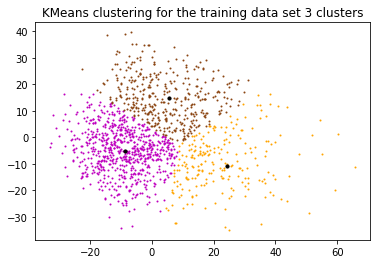

In [22]:
i = 0
plt.title("KMeans clustering for the training data set 3 clusters")
while i < 3:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , s=1, label = i, color = colors[i])
    i += 1

plt.scatter(centroids[:,0] , centroids[:,1] , s = 10, color = 'k')
plt.show()

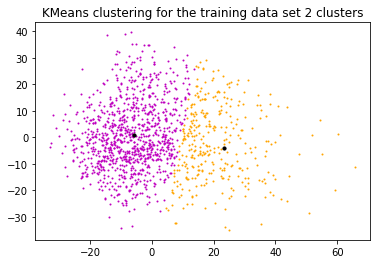

In [23]:
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1).fit(df)
label = kmeans.labels_
centroids = kmeans.cluster_centers_
i = 0
plt.title("KMeans clustering for the training data set 2 clusters")
while i < 3:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , s=1, label = i, color = colors[i])
    i += 1


plt.scatter(centroids[:,0] , centroids[:,1] , s = 10, color = 'k')
plt.show()

### Accuracy checking function

The following function checks how accurate the current model is. Given a trained model, a set of input features, and a list of actual expected output. We predict the output using the trained model and the input and compare the predicted output with the expected output. 

In [24]:
# This list stores the accuracy rate for each model
acc = dict()

def test_acc(train_actual, train_input, model):
    y_pred = model.predict(train_input)
    correct, i, length = 0, 0, len(train_actual)

    while i < length:
        if train_actual[i] == y_pred[i]:
            correct += 1
        i += 1

    print(correct/length)
    return correct/length

### K Nearest Neighbors Model prediction and accuracy checking

In this part, we will use `sklearn.KNeighborClassifier` algorithm on the data.

In [25]:
# Use k nearest neighbors with 3 neighbors
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_input, train_actual)
# Test the accuracy of this model
acc['KNN3'] = test_acc(train_actual, train_input, model)

0.38632872503840243


In [26]:
# Use k nearest neighbors with 2 neighbors
model = KNeighborsClassifier(n_neighbors=2)
model.fit(train_input, train_actual)
# Test the accuracy of this model
acc['KNN2'] = test_acc(train_actual, train_input, model)

0.5314900153609831


In [27]:
# Use k nearest neighbors with 1 neighbors
model = KNeighborsClassifier(n_neighbors=1)
model.fit(train_input, train_actual)
# Test the accuracy of this model
acc['KNN1'] = test_acc(train_actual, train_input, model)

1.0


### Support Vector Machine Model (SVM)

We will use linear SVM and radial basis SVM to test the acuracy of the model. SVMs separate data into different classes and classify the data based on which class it belongs to. If you want to learn more about what an SVM is, click [here](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)

In [28]:
# use linear support vector machine
model = svm.SVC(kernel='linear')
model.fit(train_input, train_actual, sample_weight=None)
acc['SVML'] = test_acc(train_actual, train_input, model)

0.15668202764976957


In [29]:
# use radial basis support vector machine
model = svm.SVC(kernel='rbf')
model.fit(train_input, train_actual, sample_weight=None)
acc['SVMR'] = test_acc(train_actual, train_input, model)

0.05913978494623656


### Multilayer Perceptron
Multilayer Perceptron is a type of deep learning model that utilizes forward computation, back propagation, stochastic gradient descend to train the network

In [30]:
clf = MLPClassifier(random_state=1, max_iter=1500).fit(train_input, train_actual)
acc['MLP'] = test_acc(train_actual, train_input, model)

0.05913978494623656


### Logistic Regression
We we also test the logistic regression model accuracy rate

In [31]:
# Use logistic regression to predict the data
model = LogisticRegression(solver = 'liblinear')
model.fit(train_input, train_actual, sample_weight=None)
y_pred = model.predict(train_input)
acc['LGL'] = test_acc(train_actual, train_input, model)

0.08602150537634409


In [32]:
model = LogisticRegression(solver = 'saga')
model.fit(train_input, train_actual, sample_weight=None)
y_pred = model.predict(train_input)
acc['LGS'] = test_acc(train_actual, train_input, model)

0.06912442396313365
/home/ibutz/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Finally, with all of our different models, we can generate a table of accuracy rates. The goal is to find a model to predict the NBA draft, so the highest accuracy rate should be the model we want.

In [33]:
df1 = pd.DataFrame(np.array([['KNN3', acc['KNN3']], ['KNN2', acc['KNN2']], ['KNN1', acc['KNN1']]
                        ,['SVM linear', acc['SVML']], ['SVM rbf', acc['SVMR']], ['MLP', acc['MLP']],
                            ['Logistic liblinear', acc['LGL']], ['Logistic saga', acc['LGS']]])
                   , columns=['Model', ' Accuracy'])

df1

,Model,Accuracy
0,KNN3,0.38632872503840243
1,KNN2,0.5314900153609831
2,KNN1,1.0
3,SVM linear,0.15668202764976957
4,SVM rbf,0.05913978494623656
5,MLP,0.05913978494623656
6,Logistic liblinear,0.08602150537634409
7,Logistic saga,0.06912442396313365


<a id='step3b'></a>
## Step b: Model comparisons and predictions. 

### Model Comparisons
From the above data, we can see that KNN with 1 neighbor has the highest accuracy - 1.0. But we should give it a doubt because KNN with only 1 neighbor means that every datapoint has itself as a neighbor. The second highest accuracy modelis KNN with neighbors 2- 53% accuracy rate. The models with the lowest accuracy rate are multilayer perceptrons and support vector machones with radial basis classification- 6.8% accuracy. The best model has still very low accuracy rate because we only have 1302 datapoints as our training data. We need more datapoints to improve the accuracy rate.

### Prediction on 2021 drafts
We wil pick the top 2 models and use them to predict the drafts for NBA players 2021.

In [34]:
# Use k nearest neighbors with 1 neighbors
model = KNeighborsClassifier(n_neighbors=1)
model.fit(train_input, train_actual)
y_pred1 = model.predict(test_input)
y_pred1

array([38, 50, 13, 47, 42, 33, 44, 59, 37, 28, 53, 36, 41,  8, 16, 14,  6,
       59, 11, 58, 17, 21, 50, 57, 58, 49, 29, 53, 36, 30, 38, 58, 33, 11,
       18, 53, 36, 28, 38, 41, 29, 58, 40, 27, 26,  3, 38, 26, 26, 19, 30,
       41, 40, 23, 55, 24, 41, 32, 33, 24, 37, 13, 44, 28,  6, 54, 34, 44,
       56, 47, 29, 31, 15, 50, 10, 56, 50, 33, 53])

In [35]:
# Use k nearest neighbors with 2 neighbors
model = KNeighborsClassifier(n_neighbors=2)
model.fit(train_input, train_actual)
y_pred2 = model.predict(test_input)
y_pred2

array([11,  7, 13, 44, 11, 33, 22, 34, 29, 28, 53, 36, 41,  8, 16, 14,  6,
       36, 11, 49, 17,  3,  7, 41,  1, 18, 29, 53, 26, 30, 38, 46,  6, 11,
       18, 41, 27, 19, 21, 29, 29, 30, 40, 27, 26,  3, 36, 26, 24, 13, 30,
       41, 21, 23, 18, 18, 41, 32, 29, 24, 37, 13, 34, 28,  6, 31, 24, 10,
       10, 44, 29, 31, 15, 31,  3, 11, 37, 28, 16])

In [36]:
pred_players_knn1, pred_players_knn2, i = dict(), dict(), 0
for row in test.iterrows():
    pred_players_knn1[row[1][2]] = y_pred1[i]
    pred_players_knn2[row[1][2]] = y_pred2[i]
    i += 1

In [37]:
# Predictions on players using KNN1. Just showing the top 10
sort_orders = sorted(pred_players_knn1.items(), key=lambda x: x[1])
sort_orders[:10]

[('Jose Alvarado', 3),
 ('Colin Castleton', 6),
 ('Quentin Grimes', 6),
 ('Carlik Jones', 8),
 ('Trendon Watford', 10),
 ('Damien Jefferson', 11),
 ('Isaiah Wong', 11),
 ('Alan Griffin', 13),
 ('Moussa Cisse', 13),
 ('Charles Bassey', 14)]

In [38]:
# Predictions on players with KNN2. Again, just the top 10
sort_orders = sorted(pred_players_knn2.items(), key=lambda x: x[1])
sort_orders[:10]

[("Day'Ron Sharpe", 1),
 ('David Duke', 3),
 ('Jose Alvarado', 3),
 ('Trendon Watford', 3),
 ('Colin Castleton', 6),
 ('Isaiah Jackson', 6),
 ('Quentin Grimes', 6),
 ('Aaron Wiggins', 7),
 ('David Johnson', 7),
 ('Carlik Jones', 8)]

<a id='conc'></a>
## Conclusion

First, a special shoutout to Maryland's own **Aaron Wiggins**; he is predicted to go number 7 by our KNN 2 model.

From our predictions, some of the top players include **Jose Alvardo**, **Colin Castleton**, and **Quentin Grimes**. They appear in the top 10 for both our KNN 1 and KNN 2 models. We can output some of the top draft picks from both of our models here.

In [39]:
df2 = pd.DataFrame(columns=['Player', 'Model KNN1 Pick'])
names = ['Jose Alvarado', 'Colin Castleton', 'Quentin Grimes', 'Carlik Jones', 'Trendon Watford']
model1 = [3, 6, 6, 8, 10]
model2 = [3, 6, 6, 8, 3]
df2['Player'] = names
df2['Model KNN1 Pick'] = model1
df2['Model KNN2 Pick'] = model2

df2

,Player,Model KNN1 Pick,Model KNN2 Pick
0,Jose Alvarado,3,3
1,Colin Castleton,6,6
2,Quentin Grimes,6,6
3,Carlik Jones,8,8
4,Trendon Watford,10,3


Now, we won't know the actual results of the draft until July. However, we can compare our guesses to what the sports media thinks by looking at mock drafts. These mock drafts are what people think will happen. The following websites will be looked at:

- [Hashtag Basketball](https://hashtagbasketball.com/nba-draft/nba-draft-prospects)
- [CBS sports](https://www.cbssports.com/nba/news/2021-nba-mock-draft-cade-cunningham-is-no-1-jalen-suggs-goes-no-2-but-margin-is-thin-among-top-five/)
- [Bleacher Report](https://bleacherreport.com/articles/2940680-2021-nba-mock-draft-lottery-simulation-and-1st-round-predictions)

All three of these websites have **Cade Cunningham**, a freshman from Oklahoma State, as the unanimous number 1 overall pick. Both of our models had him predicted to go around pick 36, much later in the draft. **Evan Mobley** is predicted by these mock drafts to go second overall by Hashtag Basketball and Bleacher Report, and third by CBS. Our KNN model had him picked at number 36, and our KNN 2 model had him picked at number 26.

Comparing our top picks to the mock drafts, one thing to note is CBS Sports and Bleacher Report only predicted the first round of the draft, so the top 30 picks. That said, **Jose Alvarado** and **Colin Castleton** did not appear on any of these three lists as draft picks. **Quentin Grimes** appeared only on Hashtage Basketball as the 58th best prospect, barely squeaking into the end of the draft. Sadly, our picks and the sports media's picks do not seem to align.

### How to get a better model

From our low model accuracy, to the predictions that did not match what most other people are saying, our model definitely is not the best. What would be the best ways to improve it? First, more data. As stated in the beginning(, until relatively recently (2008) NBA players did not have to attend college before playing. Many top players were drafted right from high school. If data was collected over the next ten years, the sample size would effectively be doubled, giving better insight into overall trends. 

Possibly one of the largest pieces of data we were missing was position. A point guard is typically more offensively talented, shooting, passing, and making plays. A center is larger and will have more dunks, a worse free throw percentage, and a lot of rebounds. Since we did not have positional data, all players were grouped together. Had we divided by position, perhaps there would be a relation between point guard shooting percentage and draft positions, for example. 

More data analysis in general could have been beneficial. We did not see any trends in the data, so our model was trained on all of it. If we could better refine what parameters to train our data on, perhaps the model would be more accurate.

Of course, the final test of our predictions will be the actual NBA draft. You can click [here](https://www.nba.com/draft/2021) to stay up to date or find out how to watch. Thank you for following through our data science tutorial, we hope that you were inspried to do some data analysis on your own!